https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?resource=download

In [1]:
import tensorflow as tf
import numpy as np

2024-03-05 15:48:55.287327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 15:48:55.287398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 15:48:55.288683: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 15:48:55.295819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 15:48:57.167118: W tensorflow/compiler/tf2


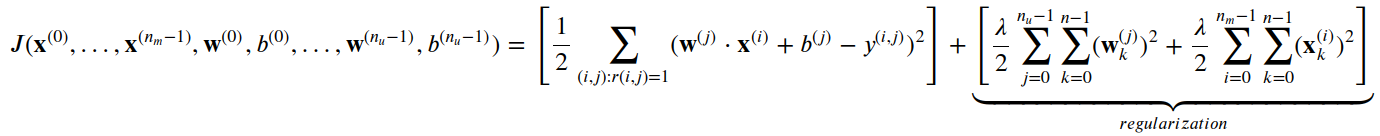  
Returns the cost for the content-based filtering  
Args:  
1. X (ndarray (num_movies,num_features)): matrix of item features  
2. W (ndarray (num_users,num_features)) : matrix of user parameters  
3. b (ndarray (1, num_users)            : vector of user parameters  
4. Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies  
5. R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user  
6. lambda_ (float): regularization parameter  

Returns:  
- J (float) : Cost  
  

In [ ]:
def cofi_cost_func(X, W, b, Y, R, lambda_):
    nm, nu = Y.shape
    J = 0  
    for i in range(nm):
        for j in range(nu):
            J += R[i][j] * (np.matmul(W[j], X[i]) + b[0][j] - Y[i][j])**2
        
    J /= 2

    copy_nu, n = W.shape
    wjk = 0.
    xik = 0.
    for j in range(nu):
        for k in range(n):
            wjk += W[j][k]**2
    
    for i in range(nm):
        for k in range(n):
            xik += X[i][k]**2
    
    J += (lambda_/2)*wjk + (lambda_/2)*xik
    return J

Misschien leuk zelf te schrijven, zelfde als boven maar dan met vectors 

In [ ]:
def cofi_cost_func_v(X, W, b, Y, R, lambda_):
    """
    Returns the cost for the content-based filtering
    Vectorized for speed. Uses tensorflow operations to be compatible with custom training loop.
    Args:
      X (ndarray (num_movies,num_features)): matrix of item features
      W (ndarray (num_users,num_features)) : matrix of user parameters
      b (ndarray (1, num_users)            : vector of user parameters
      Y (ndarray (num_movies,num_users)    : matrix of user ratings of movies
      R (ndarray (num_movies,num_users)    : matrix, where R(i, j) = 1 if the i-th movies was rated by the j-th user
      lambda_ (float): regularization parameter
    Returns:
      J (float) : Cost
    """
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)

iterations = 200
for iter in range(iterations):

    with tf.GradientTape() as tape:
        cost_value = cofi_cost_func(X, W, b, Ynorm, R, num_users, num_movies, lambda_)

    grads = tape.gradient( cost_value, [X,W,b])

    optimizer.apply_gradients( zip(grads, [X,W,b]))